# Start by defining the settting of the story and language output

In [12]:
setting = "Un jeu de rôle médiéval fantastique, dans la veine de Zork."
language = "french"
output_file = "worlds/story_world_fantasy.rdf"

In [4]:
# Whether to use Fireworks (serverless inference) or local models
USE_FIREWORKS = True

Load the LLM

In [5]:
# Importing langchain and setting verbose mode (doens't seem to work)
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Seems like this part is useless.
from langchain.globals import set_verbose
from langchain.globals import set_debug

# set_debug(True)
set_verbose(True)

model = None

In [7]:
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX


if not USE_FIREWORKS:
    # In the end, we're not using local models anymore for world generation, since it's so critical.
    # We're using Fireworks instead.
    # We used to use MLX for local inference on a Macbook Pro, but it was too slow.
    # Ollama offers a much faster inference. However, Ollama has not been implemented
    # for the world generation yet, since we're now using larger models that can't be
    # run locally.

    print("Loading local model...")
    # Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
    llm = MLXPipeline.from_model_id(
        # "mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
        # "mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
        # "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
        "mlx-community/Llama-3.2-3B-Instruct-8bit",
        pipeline_kwargs={
            "max_tokens": 2048,
            "temp": 0.2,
            "repetition_penalty": 1.2,
            "repetition_context_size": 64,
        },
    )

    # Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
    model = ChatMLX(
        llm=llm, verbose=True
    )  # .with_config({'callbacks': [ConsoleCallbackHandler()]})
    print("Model loaded.")

Option 2: Serverless inference with Fireworks

In [8]:
import getpass
import os

from dotenv import load_dotenv

load_dotenv()

# Get the Fireworks API key
if USE_FIREWORKS:
    if "FIREWORKS_API_KEY" not in os.environ:
        os.environ["FIREWORKS_API_KEY"] = getpass.getpass(
            "Enter your Fireworks API key: "
        )

In [9]:
from langchain_fireworks import ChatFireworks

if USE_FIREWORKS:
    print("Loading Fireworks model...")
    model = ChatFireworks(
        # Llama 3.3 70B
        model="accounts/fireworks/models/llama-v3p3-70b-instruct",
        # model="accounts/fireworks/models/llama-v3p1-405b-instruct"
        temperature=1,
        max_tokens=4096,
        timeout=None,
        max_retries=0,
        # other params...
    )
    print("Fireworks model loaded.")

Loading Fireworks model...
Fireworks model loaded.


Load the ontology

In [10]:
from owlready2 import *

onto = get_ontology("file://ontology/story_world_ontology.rdf").load()

In [11]:
# Verify that there are no instances in the ontology (start with a clean ontology containg only the T-Box)

with onto:
    instances = list(Thing.instances())

    if len(instances) > 0:
        for thing in instances:
            print(thing)
        raise ValueError("Ontology already contains individuals")

    print("OK")

OK


# 1. Generate the outline of the story world

In [13]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [14]:
prompt = PromptTemplate(template=OUTLINE_TEXT_PROMPT, template_format="jinja2")

chain = prompt | model

outline_text = chain.invoke({"setting": setting, "language": language}).content

print(outline_text)

Bienvenue dans le monde de Ténèbres et de Lumières, un royaume médiéval fantastique où la magie et les créatures légendaires font partie de la vie quotidienne. Le monde est divisé en quatre régions : le Royaume de la Lumière, où les chevaliers et les mages règnent en maîtres ; la Forêt Ténébreuse, un domaine mystérieux et périlleux habité par les créatures de la nuit ; les Montagnes de la Pierre, où les nains et les gobelins s'affrontent pour le contrôle des riches filons ; et la Cité des Eaux, un port cosmopolite où les marchands et les pirates se côtoient.

Vous incarnez un aventurier, un héros qui cherche à restaurer l'équilibre dans un monde menacé par les forces des Ténèbres. Votre rôle est celui d'un diplomate, d'un guerrier et d'un explorateur, capable de naviguer dans les intrigues de cour, de combattre les monstres et de résoudre les énigmes. Votre objectif principal est de retrouver les trois artefacts anciens : la Pierre de Lumière, le Sceptre de la Nuit et le Livre des Eaux

# 2. Generate locations

In [17]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define a 3-5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! **You should define all locations mentioned in the links.**

Output your work in the following JSON format:
```json
{
    "Locations": [
        {
            "name": "Suchandsuch place",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the location"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Another place"]
        },
        {
            "name": "Another place",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the location"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Suchandsuch place", "Nom d'un autre lieu"]
        },
        ...
    ],
}
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}, but keys should be in English, as shown in the example.
"""

In [18]:
prompt = PromptTemplate(template=LOCATIONS_GENERATION_PROMPT, template_format="jinja2")

parser = JsonOutputParser()

chain = prompt | model | parser

locations_output = chain.invoke({"context": outline_text, "language": language})

locations_output

{'Locations': [{'name': 'Royaume de la Lumière',
   'importance': 'major',
   'description': "Un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres, caractérisé par ses remparts imposants, ses tours élégantes et ses rues pavées. L'atmosphère y est animée, avec des marchés colorés et des tavernes bruyantes. C'est ici que vous trouverez la Pierre de Lumière, l'un des trois artefacts anciens nécessaires pour vaincre le seigneur des Ténèbres.",
   'links': ['Forêt Ténébreuse', 'Cité des Eaux']},
  {'name': 'Forêt Ténébreuse',
   'importance': 'major',
   'description': 'Un domaine mystérieux et périlleux habité par les créatures de la nuit, tels que les loups-garous, les vampires et les gobelins. La forêt est dense et sombre, avec des arbres qui semblent vous avaler dans leur ombre. Les rumeurs disent que le Sceptre de la Nuit se cache quelque part dans cette forêt, mais il faudra être prudent pour y survivre.',
   'links': ['Royaume de la Lumière', 'Montagnes d

In [19]:
location_outlines = locations_output.get("Locations")
location_outlines

[{'name': 'Royaume de la Lumière',
  'importance': 'major',
  'description': "Un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres, caractérisé par ses remparts imposants, ses tours élégantes et ses rues pavées. L'atmosphère y est animée, avec des marchés colorés et des tavernes bruyantes. C'est ici que vous trouverez la Pierre de Lumière, l'un des trois artefacts anciens nécessaires pour vaincre le seigneur des Ténèbres.",
  'links': ['Forêt Ténébreuse', 'Cité des Eaux']},
 {'name': 'Forêt Ténébreuse',
  'importance': 'major',
  'description': 'Un domaine mystérieux et périlleux habité par les créatures de la nuit, tels que les loups-garous, les vampires et les gobelins. La forêt est dense et sombre, avec des arbres qui semblent vous avaler dans leur ombre. Les rumeurs disent que le Sceptre de la Nuit se cache quelque part dans cette forêt, mais il faudra être prudent pour y survivre.',
  'links': ['Royaume de la Lumière', 'Montagnes de la Pierre']},
 {'na

Let's try to directly append new information to the KG as we go

In [20]:
# Add the generated locations to the KG
with onto:
    # Create each location entity in the graph
    for loc in location_outlines:
        loc_name = loc.get("name").strip()
        uri = encode_entity_name(loc_name)
        location = onto.Location(uri)

        location.label = loc_name
        location.hasName = loc_name
        location.hasDescription = loc.get("description")

        print(f'Created Location entity "{loc_name}"')

    # Connect each location based on their "links" property
    for loc in location_outlines:
        location = find_levenshtein_match(loc.get("name"), onto.Location.instances())
        links = loc.get("links")

        for other_location_name in links:
            other_uri = encode_entity_name(other_location_name)

            # link Location entities using the isLinkedToLocation property (symmetrical)
            other_location = find_levenshtein_match(
                other_location_name, onto.Location.instances()
            )

            # Check if the other location exists in the ontology
            if other_location is not None:
                # Link the locations using the isLinkedToLocation property
                location.isLinkedToLocation.append(other_location)
                print(f"Linked {location.hasName} to {other_location.hasName}")
            else:
                # Print a warning or handle the missing location case as needed
                print(
                    f"Warning: Location '{other_location_name}' with URI '{other_uri}' not found in ontology."
                )

Created Location entity "Royaume de la Lumière"
Created Location entity "Forêt Ténébreuse"
Created Location entity "Montagnes de la Pierre"
Created Location entity "Cité des Eaux"
Created Location entity "Château du Seigneur des Ténèbres"
Created Location entity "Village des Nains"
Created Location entity "Taverne de la Cité des Eaux"
Linked Royaume de la Lumière to Forêt Ténébreuse
Linked Royaume de la Lumière to Cité des Eaux
Linked Forêt Ténébreuse to Royaume de la Lumière
Linked Forêt Ténébreuse to Montagnes de la Pierre
Linked Montagnes de la Pierre to Forêt Ténébreuse
Linked Montagnes de la Pierre to Cité des Eaux
Linked Cité des Eaux to Royaume de la Lumière
Linked Cité des Eaux to Montagnes de la Pierre
Linked Château du Seigneur des Ténèbres to Royaume de la Lumière
Linked Château du Seigneur des Ténèbres to Forêt Ténébreuse
Linked Château du Seigneur des Ténèbres to Montagnes de la Pierre
Linked Château du Seigneur des Ténèbres to Cité des Eaux
Linked Village des Nains to Mon

Verify that the connections were made successfully

In [21]:
with onto:
    for location in onto.Location.instances():
        print(
            f"{location.hasName} is connected to: {[l.hasName for l in location.INDIRECT_isLinkedToLocation]}"
        )

Royaume de la Lumière is connected to: ['Forêt Ténébreuse', 'Château du Seigneur des Ténèbres', 'Cité des Eaux']
Forêt Ténébreuse is connected to: ['Royaume de la Lumière', 'Montagnes de la Pierre', 'Château du Seigneur des Ténèbres']
Montagnes de la Pierre is connected to: ['Cité des Eaux', 'Château du Seigneur des Ténèbres', 'Village des Nains', 'Forêt Ténébreuse']
Cité des Eaux is connected to: ['Royaume de la Lumière', 'Montagnes de la Pierre', 'Château du Seigneur des Ténèbres', 'Taverne de la Cité des Eaux']
Château du Seigneur des Ténèbres is connected to: ['Royaume de la Lumière', 'Forêt Ténébreuse', 'Cité des Eaux', 'Montagnes de la Pierre']
Village des Nains is connected to: ['Montagnes de la Pierre']
Taverne de la Cité des Eaux is connected to: ['Cité des Eaux']


In [22]:
with onto:
    for location in onto.Location.instances():
        print(f"{location.hasName}: {location.hasDescription}")

Royaume de la Lumière: Un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres, caractérisé par ses remparts imposants, ses tours élégantes et ses rues pavées. L'atmosphère y est animée, avec des marchés colorés et des tavernes bruyantes. C'est ici que vous trouverez la Pierre de Lumière, l'un des trois artefacts anciens nécessaires pour vaincre le seigneur des Ténèbres.
Forêt Ténébreuse: Un domaine mystérieux et périlleux habité par les créatures de la nuit, tels que les loups-garous, les vampires et les gobelins. La forêt est dense et sombre, avec des arbres qui semblent vous avaler dans leur ombre. Les rumeurs disent que le Sceptre de la Nuit se cache quelque part dans cette forêt, mais il faudra être prudent pour y survivre.
Montagnes de la Pierre: Un massif montagneux rocailleux où les nains et les gobelins s'affrontent pour le contrôle des riches filons. Les mines sont périlleuses, avec des tunnels étroits et des puits sans fond. Les légendes parlent d'u

## Visualize the locations topology

<Figure size 1000x800 with 0 Axes>

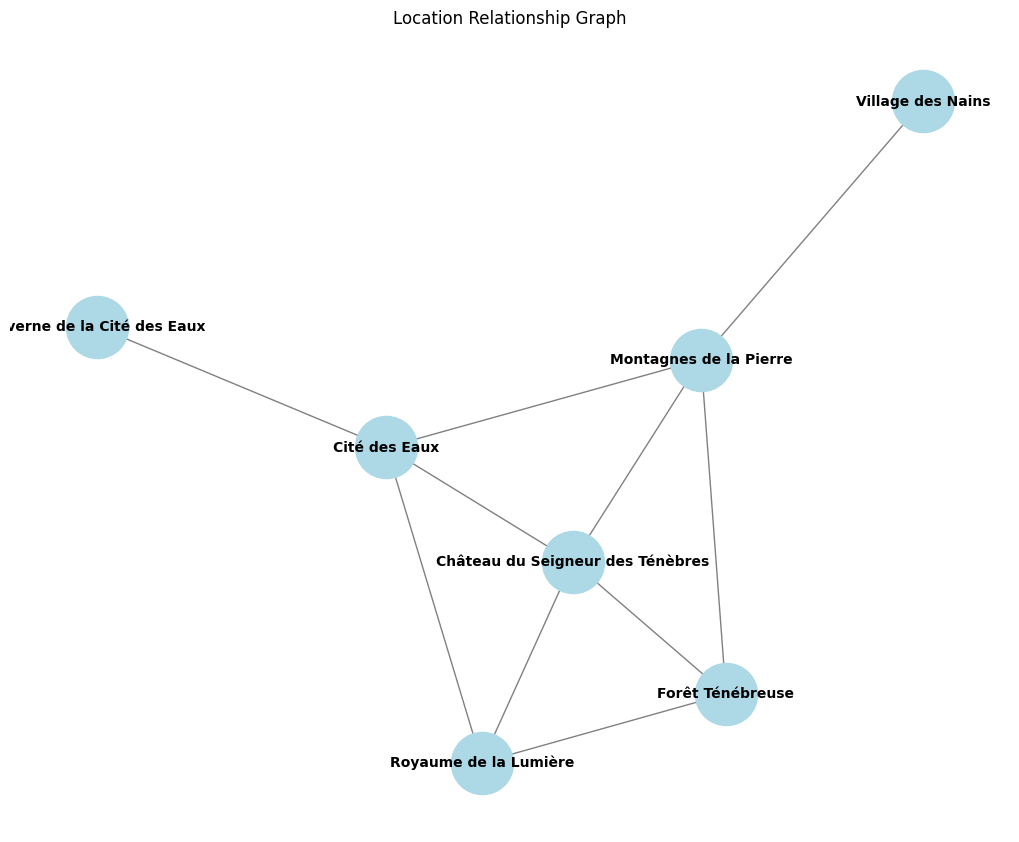

In [23]:
import networkx as nx
import matplotlib.pyplot as plt


def display_location_relationships(locations: onto.Location):
    plt.figure(figsize=(10, 8))

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.hasName)  # Add each location as a node
        for related_location in location.INDIRECT_isLinkedToLocation:
            # Create edges for relationships
            G.add_edge(location.hasName, related_location.hasName)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=2000,
        font_size=10,
        font_weight="bold",
        edge_color="gray",
    )
    plt.title("Location Relationship Graph")
    plt.show()


with onto:
    display_location_relationships(onto.Location.instances())

## Generate a structured outline of the story from the outline text and generated locations

In [24]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
```json
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte",
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (**doit** être déclenché par l'action du joueur !)",
            "consequence": "Description des conséquences à l'évènement. Ces conséquences doivent être concrètes pour le joueur",
            "location": "Nom du lieu où se déroule l'évènement. Si l'évènement est global, ne pas remplir ce champ."
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}
```

Make sure to output VALID JSON with no missing commas or other syntax errors.

# Lieux du monde
{%- for location in locations %}
- "{{location.hasName}}": {{location.hasDescription}}
  "{{location.hasName}}" mène à {%- for loc in location.INDIRECT_isLinkedToLocation %} "{{loc.hasName}}" {%- endfor %}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.
Ecris en {{language}}, sauf pour les clés JSON qui doivent rester comme dans l'exemple.

# Résultat
"""

In [25]:
prompt = PromptTemplate(template=STORY_OUTLINE_PROMPT, template_format="jinja2")

parser = JsonOutputParser()

chain = prompt | model | parser

with onto:
    # print(prompt.invoke({
    #     'setting': outline_text,
    #     'language': language,
    #     'locations': onto.Location.instances()
    # }).text)
    story_outline = chain.invoke(
        {
            "setting": outline_text,
            "language": language,
            "locations": onto.Location.instances(),
        }
    )

In [26]:
story_outline

{'Player': {'name': 'Eryndor Thorne',
  'description': "Un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Il est diplômé en magie et en stratégie militaire.",
  'location': 'Royaume de la Lumière'},
 'Characters': [{'name': 'Seigneur Arin',
   'description': 'Le seigneur des Ténèbres, un puissant sorcier qui cherche à engloutir le monde dans les ténèbres. Il est craint par tous et possède des pouvoirs dark magiques impressionnants.',
   'location': 'Château du Seigneur des Ténèbres'},
  {'name': 'Lady Lirien',
   'description': 'Une mage lumineuse, experte en magie blanche, qui guide et aide les aventuriers dans leur quête. Elle est sagesse et compassion incarnées.',
   'location': 'Royaume de la Lumière'},
  {'name': 'Gorvoth',
   'description': 'Un gobelin rusé et cruel, qui cherche à prendre le contrôle des Montagnes de la Pierre pour son propre peuple. Il est rusé et possède une armée de gobelins à se

Add the new items to the KG

In [27]:
# Add Events
with onto:
    for event_data in story_outline.get("Events"):
        event_name = event_data.get("name").strip()
        encoded_event_name = encode_entity_name(event_name)

        event = onto.Event(event_name)
        event.hasName = event_name
        event.label = event_name
        event.hasDescription = event_data.get("description")
        event.hasCondition = event_data.get("condition")
        event.hasConsequence = event_data.get("consequence")
        print(f'Created Event entity "{event_name}"')
        print(f"Description: {event.hasDescription}")
        print(f"Condition: {event.hasCondition}")
        print(f"Consequence: {event.hasConsequence}\n")

Created Event entity "La rencontre avec Lady Lirien"
Description: Le joueur rencontre Lady Lirien, qui lui explique la situation actuelle et lui donne des conseils pour commencer sa quête.
Condition: Arriver au Royaume de la Lumière et parler avec Lady Lirien.
Consequence: Le joueur reçoit des informations sur les artefacts et les régions à explorer.

Created Event entity "L'attaque des gobelins"
Description: Les gobelins de Gorvoth attaquent le Village des Nains, et le joueur doit les repousser pour sauver les nains.
Condition: Arriver au Village des Nains pendant l'attaque.
Consequence: Le joueur gagne la gratitude des nains et obtient des informations sur les Montagnes de la Pierre.



In [28]:
# Add Characters
with onto:
    for char in story_outline.get("Characters"):
        print("DEBUG: ", char)
        # First, make sure the location is correct
        loc_name = char.get("location")
        character_location = find_levenshtein_match(loc_name, onto.Location.instances())

        if not character_location:
            print(f"Warning: {name}'s location {loc_name} not found in ontology. ")
            continue

        # Create new character
        name = char.get("name")
        encoded_name = encode_entity_name(name)

        character = onto.Character(encoded_name)
        character.hasName = name
        character.label = name
        character.hasDescription = char.get("description")
        character.hasImportance = "main character"
        character.characterIsLocatedAt = character_location

        print(
            f"{character.hasName} ({character.INDIRECT_isLocatedAt.hasName}): {character.hasDescription}"
        )

DEBUG:  {'name': 'Seigneur Arin', 'description': 'Le seigneur des Ténèbres, un puissant sorcier qui cherche à engloutir le monde dans les ténèbres. Il est craint par tous et possède des pouvoirs dark magiques impressionnants.', 'location': 'Château du Seigneur des Ténèbres'}
Seigneur Arin (Château du Seigneur des Ténèbres): Le seigneur des Ténèbres, un puissant sorcier qui cherche à engloutir le monde dans les ténèbres. Il est craint par tous et possède des pouvoirs dark magiques impressionnants.
DEBUG:  {'name': 'Lady Lirien', 'description': 'Une mage lumineuse, experte en magie blanche, qui guide et aide les aventuriers dans leur quête. Elle est sagesse et compassion incarnées.', 'location': 'Royaume de la Lumière'}
Lady Lirien (Royaume de la Lumière): Une mage lumineuse, experte en magie blanche, qui guide et aide les aventuriers dans leur quête. Elle est sagesse et compassion incarnées.
DEBUG:  {'name': 'Gorvoth', 'description': 'Un gobelin rusé et cruel, qui cherche à prendre le c

In [29]:
# Verify results
with onto:
    # sync_reasoner()
    for loc in onto.Location.instances():
        print(f"{loc.hasName}: {[char.hasName for char in loc.containsCharacter]}")

Royaume de la Lumière: ['Lady Lirien']
Forêt Ténébreuse: []
Montagnes de la Pierre: ['Gorvoth']
Cité des Eaux: ['Capitaine Ryker']
Château du Seigneur des Ténèbres: ['Seigneur Arin']
Village des Nains: []
Taverne de la Cité des Eaux: []


In [30]:
# Add Items
for item_data in story_outline.get("Items"):
    print("DEBUG: ", item_data)
    item_name = item_data.get("name")
    encoded_name = encode_entity_name(encoded_name)

    item = onto.Item(encoded_name)
    item.hasName = item_name
    item.label = item_name
    item.hasDescription = item_data.get("description")
    item.hasQuantity = item_data.get("quantity", 1)
    item.hasImportance = "major"

    item_location_name = item_data.get("location")

    # Find the location among existing locations using fuzzy matching (using Levenshtein distance)
    item_location = find_levenshtein_match(
        item_location_name, onto.Location.instances()
    )

    if not item_location:
        print(f"Warning: item's location {item_location_name} not found in ontology.")
        continue

    item.itemIsLocatedAt = item_location

    print(
        f"{item.hasName} ({item.INDIRECT_isLocatedAt.hasName}): {item.hasDescription}"
    )

DEBUG:  {'name': 'Pierre de Lumière', 'description': 'Un artefact lumineux qui donne au porteur une grande puissance magique.', 'location': 'Royaume de la Lumière'}
Pierre de Lumière (Royaume de la Lumière): Un artefact lumineux qui donne au porteur une grande puissance magique.
DEBUG:  {'name': 'Sceptre de la Nuit', 'description': 'Un artefact sombre qui permet au porteur de contrôler les créatures des Ténèbres.', 'location': 'Forêt Ténébreuse'}
Sceptre de la Nuit (Forêt Ténébreuse): Un artefact sombre qui permet au porteur de contrôler les créatures des Ténèbres.
DEBUG:  {'name': 'Livre des Eaux', 'description': "Un artefact ancient qui contient des secrets sur la magie de l'eau et la navigation.", 'location': 'Cité des Eaux'}
Livre des Eaux (Cité des Eaux): Un artefact ancient qui contient des secrets sur la magie de l'eau et la navigation.


In [31]:
print(f"{item.hasName} ({item.INDIRECT_isLocatedAt.hasName}): {item.hasDescription}")

Livre des Eaux (Cité des Eaux): Un artefact ancient qui contient des secrets sur la magie de l'eau et la navigation.


In [32]:
# Player and player's goal
with onto:
    # Create the Player entity
    player_data = story_outline.get("Player")
    player_name = player_data.get("name")
    encoded_name = encode_entity_name(player_name)

    player = onto.Player(encoded_name)
    player.hasName = player_name
    player.label = player_name
    player.hasDescription = player_data.get("description")
    player.hasImportance = "Player"

    # Give the player its location
    player_location_name = player_data.get("location")

    player_location = find_levenshtein_match(
        player_location_name, onto.Location.instances()
    )

    if player_location:
        player.characterIsLocatedAt = player_location
    else:
        print(
            f"Warning: {player_name}'s location {player_location_name} not found in ontology. "
        )

    goal_data = story_outline.get("Goal")
    # Create the player's Goal entity
    goal_description = goal_data.get("description")

    goal = onto.Goal("player_goal")
    goal.label = "Player goal"
    goal.hasDescription = goal_description

    required_item_name = goal_data.get("requiresItem")
    print(f"Required item name: {required_item_name}")
    required_item = find_levenshtein_match(required_item_name, onto.Item.instances())
    print(f"Required item: {required_item.hasName if required_item else 'None'}")
    if required_item:
        goal.requiresItem.append(required_item)

    print(goal)
    player.hasGoal.append(goal)

    print(
        f"{player.hasName} ({player.INDIRECT_isLocatedAt.hasName}): {player.hasDescription}"
    )
    print(f"Goal: {player.hasGoal[0].hasDescription}")
    print(f"Requires item: {player.hasGoal[0].requiresItem}")

Required item name: Pierre de Lumière, Sceptre de la Nuit, Livre des Eaux
Required item: None
story_ontology3.player_goal
Eryndor Thorne (Royaume de la Lumière): Un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Il est diplômé en magie et en stratégie militaire.
Goal: Récupérer les trois artefacts anciens (Pierre de Lumière, Sceptre de la Nuit et Livre des Eaux) pour vaincre le seigneur des Ténèbres et restaurer l'équilibre dans le monde.
Requires item: []


In [33]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.hasName}}
Description: {{character.hasDescription}}
Starting location: {{character.isLocatedAt.hasName}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}

The player:
    "{{ player.hasName }}": {{ player.hasDescription }} (is located at {{player.INDIRECT_isLocatedAt.hasName}})
    The player has the goal: {{player.hasGoal[0].hasDescription}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the exact following JSON format:

```json
{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts, all inside this description string",
    "relationships": [
        {
            "type": "The type of relationship from this character to the target character. Either 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.hasName}}"
        },
        ...
    ]
}
```

**The relationship types should be chosen EXCLUSIVELY between: 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language !!**

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [34]:
prompt = PromptTemplate(template=CHARACTER_EXPANSION_PROMPT, template_format="jinja2")

parser = JsonOutputParser()

chain = prompt | model | parser

characters = onto.Character.instances()

# Expand each character's description and relationships
for character in characters:
    if onto.Player in character.is_a:
        continue

    print(character.hasName)

    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        # skip self
        if other_character.hasName == character.hasName:
            continue
        other_characters.append(other_character)

    print(character)

    # print(prompt.invoke({"setting": outline_text,
    #                     "character": character,
    #                     "player": onto.Player.instances()[0],
    #                     "other_characters": other_characters,
    #                     "language": language}).text)
    # continue

    res = chain.invoke(
        {
            "setting": outline_text,
            "character": character,
            "player": onto.Player.instances()[0],
            "other_characters": other_characters,
            "language": language,
        }
    )

    # Update the character in the ontology
    character.hasLongDescription = res.get("description")

    for relationship in res.get("relationships"):
        #'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler'
        relationship_type = relationship.get("type")
        related_character_name = relationship.get("target")
        related_character = find_levenshtein_match(
            related_character_name, onto.Character.instances()
        )

        if not related_character:
            print(
                f"Warning: {character.hasName}'s relation {related_character_name} not found in ontology."
            )
            continue

        if relationship_type == "friend":
            character.hasFriendshipWith.append(related_character)
        elif relationship_type == "lover":
            character.loves.append(related_character)
        elif relationship_type == "enemy":
            character.isEnemyWith.append(related_character)
        elif relationship_type == "rival":
            character.hasRivalryWith.append(related_character)
        elif relationship_type == "subject":
            character.hasAllegiance.append(related_character)
        elif relationship_type == "ruler":
            character.isRulerOf.append(related_character)
            # related_character.hasAllegiance = [this_character]
        elif relationship_type == "knows":
            character.knows.append(related_character)

    print("----*----")
    print(res)
    print("\n\n")
    print(f"Name: {character.hasName}")
    print(f"Location: {character.INDIRECT_isLocatedAt.hasName}")
    print(f"Description: {character.hasDescription}")
    print(f"Long description: {character.hasLongDescription}")
    print(f"Knows: {character.INDIRECT_knows}")
    print(f"Friends: {character.INDIRECT_hasFriendshipWith}")
    print(f"Rivals: {character.INDIRECT_hasRivalryWith}")
    print(f"Enemies: {character.INDIRECT_isEnemyWith}")
    print(f"Has allegiance to: {character.INDIRECT_hasAllegiance}")
    print(f"Is ruler of: {character.INDIRECT_isRulerOf}")
    print(f"Loves: {character.INDIRECT_loves}")
    # print(f"Relationships: {character.}")
    print("----*----")

Seigneur Arin
story_ontology3.seigneur%20arin
----*----
{'description': "Le seigneur des Ténèbres, un puissant sorcier qui cherche à engloutir le monde dans les ténèbres. Il est craint par tous et possède des pouvoirs dark magiques impressionnants. Son passé est marqué par une tragédie : il a perdu sa famille et son royaume à cause de la lumière qui a détruit tout ce qu'il aimait. Depuis, il cherche à se venger en plongeant le monde dans les ténèbres. Il est actuellement en train de rassembler ses forces pour lancer une attaque contre le Royaume de la Lumière.", 'relationships': [{'type': 'enemy', 'target': 'Eryndor Thorne'}, {'type': 'rival', 'target': 'Lady Lirien'}]}



Name: Seigneur Arin
Location: Château du Seigneur des Ténèbres
Description: Le seigneur des Ténèbres, un puissant sorcier qui cherche à engloutir le monde dans les ténèbres. Il est craint par tous et possède des pouvoirs dark magiques impressionnants.
Long description: Le seigneur des Ténèbres, un puissant sorcier qu

In [31]:
# Verify consistency and make inferences
# with onto:
#     sync_reasoner()

Great ! We have expanded our characters ! They now have relationships and backstories, this should be interesting !


## Expand Locations

In [35]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.hasName}}
Description: {{location.hasDescription}}
Neighboring locations:
{%- for nearby_location in location.INDIRECT_isLinkedToLocation %}
    - "{{ nearby_location.hasName }}": {{nearby_location.hasDescription}}
{%- endfor %}

{%- if location.containsCharacter %}
Main characters in "{{location.hasName}}":
{%- for character in location.containsCharacter %}
    - "{{ character.hasName }}" {% if onto.Player in character.is_a %}(Player){%- endif %}: {{ character.hasDescription }}
{%- endfor %}
{%- endif %}

{%- if location.containsItem %}
The location contains the quest item(s):
{%- for item in location.containsItem %}
    - "{{ item.hasName }}" ({{item.hasImportance}}): {{ item.hasDescription }}
{%- endfor %}
{%- endif %}

Please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story. You can and should use less, or even no characters, depending on the location ! Only add characters where pertinent.
- Up to three items that could be found or are important in this location. Items should always have a clear use at least in the scene.

You CAN add less characters and items than requested, but you MUST NOT add more than requested.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

```json
{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story",
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its state and function.",
            "quantity": 1
        },
        ...
    ]
}
```

Generate all output in {{ language }}
"""

In [36]:
prompt = PromptTemplate(template=LOCATION_EXPANSION_PROMPT, template_format="jinja2")

parser = JsonOutputParser()

chain = prompt | model | parser


# banned_character_names = all_character_names
# banned_item_names = all_item_names


for location in onto.Location.instances():
    print(f"Name: {location.hasName}")
    print(location.containsCharacter)

    # Prevent LLM from generating the same items over and over.
    # This improves creativity, and coherence between prompts, since the LLM is
    # at least aware of what kind of items already exist.
    banned_item_names = [i.hasName for i in onto.Item.instances()]
    banned_character_names = [c.hasName for c in onto.Character.instances()]
    used_roles = [c.hasRole for c in onto.Character.instances() if c.hasRole]

    # print(prompt.invoke({"setting": outline_text,
    #                      "onto": onto,
    #                      "location": location,
    #                      "banned_item_names": banned_item_names,
    #                      "banned_character_names": banned_character_names,
    #                      "used_roles": used_roles,
    #                      "language": language}).text)
    # break

    res = chain.invoke(
        {
            "setting": outline_text,
            "onto": onto,
            "location": location,
            "banned_item_names": banned_item_names,
            "banned_character_names": banned_character_names,
            "used_roles": used_roles,
            "language": language,
        }
    )

    print(res)

    # Update KG with this expanded information
    # Updated long description
    location.hasLongDescription = res.get("Description")

    # New secondary Characters
    for char in res.get("Characters"):
        char_name = char.get("name")
        encoded_char_name = encode_entity_name(char_name)

        character = onto.Character(encoded_char_name)
        character.hasName = char_name
        character.label = char_name
        character.hasDescription = char.get("description")
        character.hasRole.append(char.get("role"))
        character.hasImportance = "secondary"
        character.characterIsLocatedAt = location

    for item_data in res.get("Items"):
        item_name = item_data.get("name")
        encoded_item_name = encode_entity_name(item_name)

        item = onto.Item(encoded_item_name)
        item.hasName = item_name
        item.label = item_name
        item.hasDescription = item_data.get("description")
        item.hasImportance = "minor"
        item.itemIsLocatedAt = location

    print("\n")
    print(f"Location name: {location.hasName}")
    print(f"Description: {location.hasDescription}")
    print(f"Long description: {location.hasLongDescription}")
    print(f"Characters: {location.INDIRECT_containsCharacter}")
    print(f"Items: {location.INDIRECT_containsItem}")
    print("----*----")

Name: Royaume de la Lumière
[story_ontology3.lady%20lirien, story_ontology3.eryndor%20thorne]
{'Description': 'Le Royaume de la Lumière est un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres. Les remparts imposants, les tours élégantes et les rues pavées caractérisent ce lieu animé, avec des marchés colorés et des tavernes bruyantes. La Pierre de Lumière, un artefact lumineux qui donne au porteur une grande puissance magique, se trouve ici. Les aventuriers peuvent explorer les différents quartiers, rencontrer des personnages intrigants et affronter des défis pour atteindre leur objectif.', 'Characters': [{'name': 'Maître Armand', 'description': 'Un vieux mage qui enseigne la magie blanche aux élèves du royaume. Il peut fournir des informations sur la Pierre de Lumière et les dangers qui la protègent.', 'role': 'Informateur'}, {'name': 'Guillaume le Forgeron', 'description': "Un forgeron réputé pour ses armes et armures de haute qualité. Il peut proposer d

In [37]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isLocatedAt

        print(f"{character.hasName} is located at {loc.hasName}")

    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {[c.hasName for c in characters]}")

Seigneur Arin is located at Château du Seigneur des Ténèbres
Lady Lirien is located at Royaume de la Lumière
Gorvoth is located at Montagnes de la Pierre
Capitaine Ryker is located at Cité des Eaux
Maître Armand is located at Royaume de la Lumière
Guillaume le Forgeron is located at Royaume de la Lumière
Elara la Chasseuse is located at Forêt Ténébreuse
Thrain le Corbeau is located at Forêt Ténébreuse
Kragnir is located at Montagnes de la Pierre
Xandria is located at Montagnes de la Pierre
Lysandra la Navigateuse is located at Cité des Eaux
Kael le Maréchal is located at Cité des Eaux
Lyra la Captive is located at Château du Seigneur des Ténèbres
Korvus le Gardien is located at Château du Seigneur des Ténèbres
Balandir is located at Village des Nains
Kragna is located at Village des Nains
Ragnar le Marin is located at Taverne de la Cité des Eaux
Lila la Courtière is located at Taverne de la Cité des Eaux
Eryndor Thorne is located at Royaume de la Lumière
Royaume de la Lumière contains:

In [38]:
with onto:
    for character in onto.Character.instances():
        print(
            f"{character.hasName} friends with: {character.INDIRECT_hasFriendshipWith}"
        )

Seigneur Arin friends with: []
Lady Lirien friends with: [story_ontology3.lady%20lirien, story_ontology3.eryndor%20thorne]
Gorvoth friends with: []
Capitaine Ryker friends with: []
Maître Armand friends with: []
Guillaume le Forgeron friends with: []
Elara la Chasseuse friends with: []
Thrain le Corbeau friends with: []
Kragnir friends with: []
Xandria friends with: []
Lysandra la Navigateuse friends with: []
Kael le Maréchal friends with: []
Lyra la Captive friends with: []
Korvus le Gardien friends with: []
Balandir friends with: []
Kragna friends with: []
Ragnar le Marin friends with: []
Lila la Courtière friends with: []
Eryndor Thorne friends with: [story_ontology3.lady%20lirien, story_ontology3.eryndor%20thorne]


## Visualize the character relationships

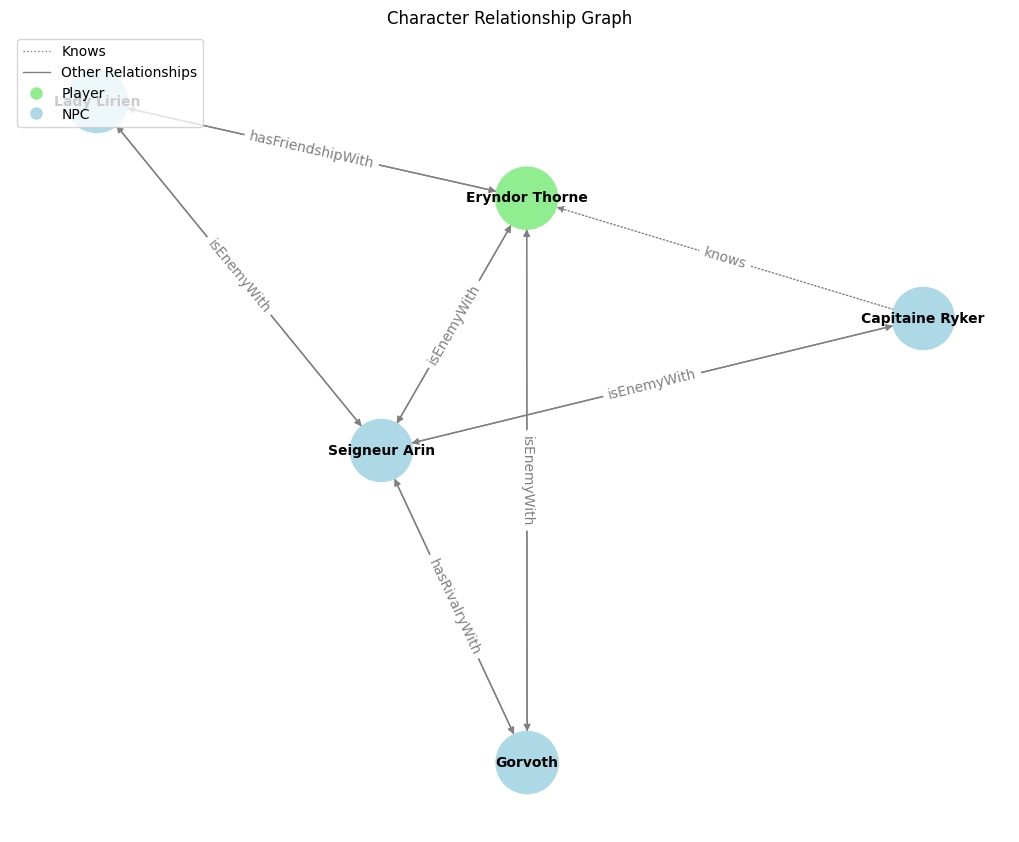

In [39]:
from matplotlib.lines import Line2D


def display_character_relationships(characters):
    plt.figure(figsize=(10, 8))

    # Create a directed graph
    G = nx.DiGraph()

    # Define primary relationship and sub-relationship properties of interest
    knows_relationships = [
        onto.knows,
        onto.hasFriendshipWith,
        onto.hasAllegiance,
        onto.hasFamilyTieWith,
        onto.isEnemyWith,
        onto.hasRivalryWith,
        onto.loves,
    ]

    # Create a dictionary to store edge styles
    edge_styles = {}  # Changed from list to dict

    # Add nodes and edges based on relationships
    for prop in knows_relationships:
        for relation in prop.get_relations():
            subject = relation[0].hasName
            obj = relation[1].hasName

            if subject and obj:
                G.add_node(subject)
                G.add_node(obj)

                # Store edge style in dictionary using (subject, obj) as key
                edge_style = "dotted" if prop.name == "knows" else "solid"
                edge_styles[(subject, obj)] = edge_style

                # Determine if an edge already exists between the characters
                existing_edge = G.get_edge_data(subject, obj)

                # Check if the current property is a narrower relationship
                if existing_edge:
                    existing_label = existing_edge["label"]
                    existing_property = getattr(onto, existing_label, None)
                    is_narrower_relationship = existing_property in prop.is_a
                else:
                    is_narrower_relationship = True

                # Add or replace the edge with the narrower relationship
                if not existing_edge or is_narrower_relationship:
                    G.add_edge(subject, obj, label=prop.name)

    # Choose a layout
    pos = nx.kamada_kawai_layout(G)

    player_name = onto.Player.instances()[0].hasName
    # Draw nodes with custom color for the player
    node_colors = [
        "lightgreen" if node == player_name else "lightblue" for node in G.nodes
    ]

    # Draw edges using stored styles
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=10,
        font_weight="bold",
        edge_color="gray",
        style=[
            edge_styles.get((u, v), "solid") for u, v in G.edges()
        ],  # Get style from dictionary
        arrows=True,
    )

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color="grey", font_size=10
    )

    # Create legend for edge styles
    legend_elements = [
        Line2D([0], [0], color="gray", lw=1, label="Knows", linestyle="dotted"),
        Line2D(
            [0], [0], color="gray", lw=1, label="Other Relationships", linestyle="solid"
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Player",
            markerfacecolor="lightgreen",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="NPC",
            markerfacecolor="lightblue",
            markersize=10,
        ),
    ]
    plt.legend(handles=legend_elements, loc="upper left")

    plt.title("Character Relationship Graph")
    plt.show()


with onto:
    display_character_relationships(onto.Character.instances())

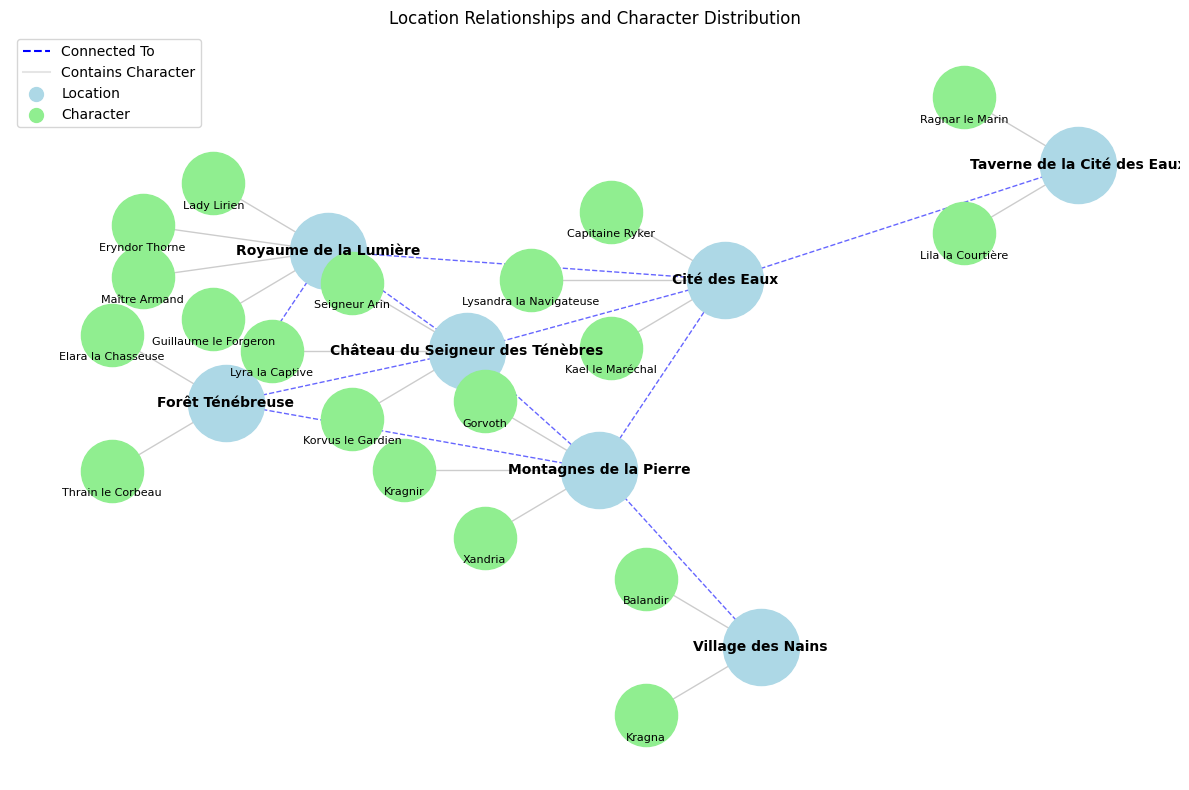

In [40]:
import numpy as np


def display_character_distribution():
    plt.figure(figsize=(12, 8))
    G = nx.Graph()

    # Add all locations as nodes and their relationships
    locations = list(onto.Location.instances())
    characters_by_location = {}

    # First pass: Add locations and track characters
    for location in locations:
        G.add_node(location.hasName, type="location")
        characters_by_location[location.hasName] = []

        # Add characters in this location
        for character in location.containsCharacter:
            G.add_node(character.hasName, type="character")
            G.add_edge(location.hasName, character.hasName, type="contains")
            characters_by_location[location.hasName].append(character.hasName)

    # Second pass: Add location relationships
    for location in locations:
        # Add connected locations
        for connected_loc in location.isLinkedToLocation:
            G.add_edge(location.hasName, connected_loc.hasName, type="connected")

    # Position nodes
    pos = {}

    # First, position locations in a circle
    location_nodes = [
        node
        for node, attr in G.nodes(data=True)
        if "type" not in attr or attr["type"] == "location"
    ]
    location_pos = nx.spring_layout(G.subgraph(location_nodes), k=1.0)
    pos.update(location_pos)

    # Then, position characters in a semi-circle around their location
    for location, characters in characters_by_location.items():
        if not characters:
            continue

        loc_x, loc_y = pos[location]
        num_chars = len(characters)

        # Create a semi-circle of characters around the location
        radius = 0.3  # Distance from location to characters
        for i, character in enumerate(characters):
            angle = np.pi * (0.7 + 0.6 * i / max(1, num_chars - 1))
            char_x = loc_x + radius * np.cos(angle)
            char_y = loc_y + radius * np.sin(angle)
            pos[character] = (char_x, char_y)

    # Draw different types of edges
    edges_contains = [
        (u, v) for (u, v, d) in G.edges(data=True) if d["type"] == "contains"
    ]
    edges_connected = [
        (u, v) for (u, v, d) in G.edges(data=True) if d["type"] == "connected"
    ]
    edges_partof = [(u, v) for (u, v, d) in G.edges(data=True) if d["type"] == "partof"]

    # Draw locations
    nx.draw_networkx_nodes(
        G, pos, nodelist=location_nodes, node_color="lightblue", node_size=3000
    )

    # Draw characters
    character_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("type") == "character"
    ]
    nx.draw_networkx_nodes(
        G, pos, nodelist=character_nodes, node_color="lightgreen", node_size=2000
    )

    # Draw different types of edges
    nx.draw_networkx_edges(G, pos, edgelist=edges_contains, alpha=0.2, style="-")
    nx.draw_networkx_edges(
        G, pos, edgelist=edges_connected, alpha=0.6, style="--", edge_color="blue"
    )
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges_partof,
        alpha=0.6,
        style="-",
        edge_color="red",
        arrows=True,
    )

    # Draw labels
    location_labels = {node: node for node in location_nodes}
    character_labels = {node: node for node in character_nodes}

    nx.draw_networkx_labels(G, pos, location_labels, font_size=10, font_weight="bold")

    # Slightly offset character labels
    char_pos = {
        node: (coord[0], coord[1] - 0.08)
        for node, coord in pos.items()
        if node in character_nodes
    }
    nx.draw_networkx_labels(G, char_pos, character_labels, font_size=8)

    # Add legend
    legend_elements = [
        Line2D([0], [0], color="blue", linestyle="--", label="Connected To"),
        Line2D(
            [0], [0], color="gray", linestyle="-", alpha=0.2, label="Contains Character"
        ),
        plt.scatter([], [], c="lightblue", s=100, label="Location"),
        plt.scatter([], [], c="lightgreen", s=100, label="Character"),
    ]
    plt.legend(handles=legend_elements, loc="upper left")

    plt.title("Location Relationships and Character Distribution")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


display_character_distribution()

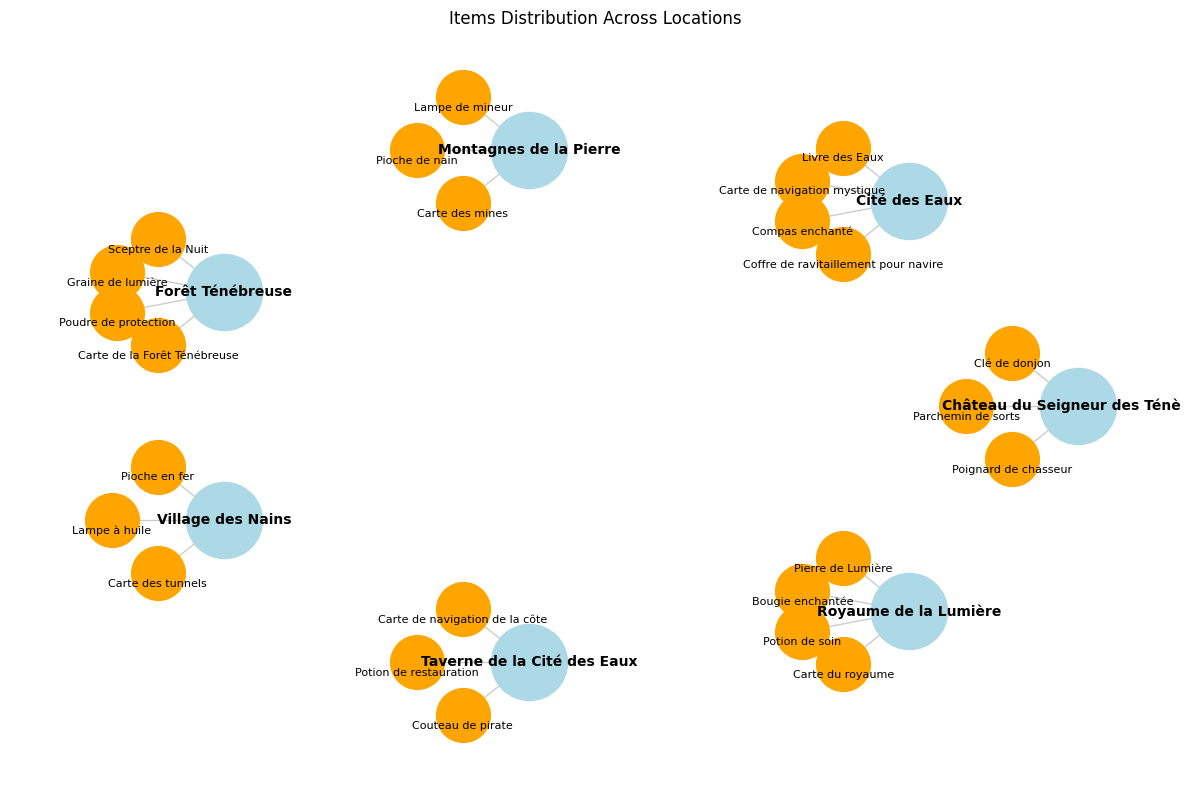

In [41]:
def display_item_distribution():
    plt.figure(figsize=(12, 8))
    G = nx.Graph()

    # Add all locations as nodes
    locations = list(onto.Location.instances())
    items_by_location = {}

    for location in locations:
        G.add_node(location.hasName, type="location")
        items_by_location[location.hasName] = []

        # Add items in this location and connect them
        for item in location.containsItem:
            G.add_node(item.hasName, type="item")
            G.add_edge(location.hasName, item.hasName)
            items_by_location[location.hasName].append(item.hasName)

    # Use a circular layout for locations, then adjust item positions
    pos = {}

    # First, position locations in a circle
    location_nodes = [
        node
        for node, attr in G.nodes(data=True)
        if "type" not in attr or attr["type"] == "location"
    ]
    location_pos = nx.circular_layout(G.subgraph(location_nodes), scale=2.0)
    pos.update(location_pos)

    # Then, position items in a semi-circle around their location
    for location, items in items_by_location.items():
        if not items:
            continue

        loc_x, loc_y = pos[location]
        num_items = len(items)

        # Create a semi-circle of items around the location
        radius = 0.5  # Distance from location to items
        for i, item in enumerate(items):
            angle = np.pi * (
                0.7 + 0.6 * i / max(1, num_items - 1)
            )  # Spread items in a 180-degree arc
            item_x = loc_x + radius * np.cos(angle)
            item_y = loc_y + radius * np.sin(angle)
            pos[item] = (item_x, item_y)

    # Draw locations
    nx.draw_networkx_nodes(
        G, pos, nodelist=location_nodes, node_color="lightblue", node_size=3000
    )

    # Draw items
    item_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("type") == "item"
    ]
    nx.draw_networkx_nodes(
        G, pos, nodelist=item_nodes, node_color="orange", node_size=1500
    )

    # Draw edges with some transparency
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Draw labels with different colors and slight offsets for better readability
    location_labels = {node: node for node in location_nodes}
    item_labels = {node: node for node in item_nodes}

    nx.draw_networkx_labels(G, pos, location_labels, font_size=10, font_weight="bold")

    # Slightly offset item labels
    item_pos = {
        node: (coord[0], coord[1] - 0.08)
        for node, coord in pos.items()
        if node in item_nodes
    }
    nx.draw_networkx_labels(G, item_pos, item_labels, font_size=8)

    plt.title("Items Distribution Across Locations")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


display_item_distribution()

## Raffiner le joueur

In [42]:
PLAYER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the player.

Player Name: {{player.hasName}}
Description: {{player.hasDescription}}
Starting location: {{player.INDIRECT_isLocatedAt.hasName}}

{%- if player.INDIRECT_knows %}
Other main characters of the story:
{%- for char in player.INDIRECT_knows %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}
{%- endif %}

Items present in the world (**DO NOT REUSE THESE ITEMS**): {{items_in_world}}

Please give the player an inventory, with up to 3 items, such as a weapon, a tool, some consumables, etc. that the player can use to start their adventure.

Use the same JSON format as the example below:
```json
{
    "description": "An updated and expanded description of the player including their goals, motivations, and conflicts.",
    "inventory": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1
        },
        ...
    ]
}
```

Output all the JSON value strings in {{ language }}
"""

In [43]:
player_prompt = PromptTemplate(
    template=PLAYER_EXPANSION_PROMPT, template_format="jinja2"
)

items_in_world = [i.hasName for i in onto.Item.instances()]

parameters = {
    "player": onto.Player.instances()[0],
    "items_in_world": items_in_world,
    "language": language,
}

prompt = player_prompt.invoke(parameters)
print(prompt.text)

parser = JsonOutputParser()

chain = player_prompt | model | parser

player_expansion = chain.invoke(parameters)
print(player_expansion)


Using the following details, generate a JSON output with additional information about the player.

Player Name: Eryndor Thorne
Description: Un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Il est diplômé en magie et en stratégie militaire.
Starting location: Royaume de la Lumière
Other main characters of the story:
    "Lady Lirien": Une mage lumineuse, experte en magie blanche, qui guide et aide les aventuriers dans leur quête. Elle est sagesse et compassion incarnées. (is located at Royaume de la Lumière)
    "Eryndor Thorne": Un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Il est diplômé en magie et en stratégie militaire. (is located at Royaume de la Lumière)
    "Gorvoth": Un gobelin rusé et cruel, qui cherche à prendre le contrôle des Montagnes de la Pierre pour son propre peuple. Il est rusé et possède une armée d

In [44]:
# Add the new information to the KG
with onto:
    player = onto.Player.instances()[0]
    player.hasLongDescription = player_expansion.get("description")

    print(f"Long description of the player: {player.hasLongDescription}")

    print("Items in the player's inventory:")
    # Add the items in the player's inventory to the KG
    for item in player_expansion.get("inventory"):
        item_name = item.get("name")
        item_description = item.get("description")
        item_quantity = item.get("quantity")
        item_encoded_name = encode_entity_name(item_name)

        print(f" - {item_name}: {item_description}")

        item = onto.Item(item_encoded_name)
        item.hasName = item_name
        item.hasDescription = item_description
        item.hasQuantity = item_quantity

        player.ownsItem.append(item)

Long description of the player: Un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Il est diplômé en magie et en stratégie militaire. Son objectif principal est de vaincre le Seigneur Arin et mettre fin à son règne de terreur. Il est motivé par un sens du devoir envers sa famille et son royaume, ainsi que par le désir de protéger les innocents.
Items in the player's inventory:
 - Poignard de chasseur: Un poignard léger et polyvalent, utile pour la chasse et le combat rapproché.
 - Potion de soin: Une potion qui restaure la santé du joueur, utile en cas d'urgence ou de blessure.
 - Carte du royaume: Une carte détaillée du royaume, permettant au joueur de naviguer et de localiser les différents lieux et personnages.


In [45]:
with onto:
    onto.save(file=output_file, format="rdfxml")

# Pre-generate the first message


In [49]:
FIRST_TURN_PROMPT = """
You are an LLM designed to act as the engine for a text adventure game set in "{{setting}}".

List of the locations that make up this game's world (to give you general context):
{%- for location in locations %}
    - {{ location.hasName }}: {{location.hasDescription}}
{%- endfor %}

The player ("{{player.hasName}}") is located at {{player_start_location_name}}.
The locations accessible from where the player is are {{nearby_locations_names}}

{%- if characters_nearby %}
Characters present in {{location.hasName}}:
{%- for character in characters_nearby %}
    - {{ character.hasName }}: {{character.hasDescription}} (narrative importance {{character.hasImportance}})\n
        {%- if character.INDIRECT_knows -%}knows: {%- for known_character in character.INDIRECT_knows %} {{ known_character.hasName }} {% endfor %}\n{% endif %}
        {%- if character.INDIRECT_isEnemyWith -%}is enemy with: {%- for enemy in character.INDIRECT_isEnemyWith %} {{ enemy.hasName }} {% endfor %}\n{% endif %}
        {%- if character.INDIRECT_hasFriendshipWith -%}is friend with: {%- for friend in character.INDIRECT_hasFriendshipWith %} {{ friend.hasName }} {% endfor %}\n{% endif %}
        {%- if character.INDIRECT_isRivalWith -%}is rival with: {%- for rival in character.INDIRECT_isRivalWith %} {{ rival.hasName }} {% endfor %}\n{% endif %}
        {%- if character.INDIRECT_loves -%}is in love with: {%- for love in character.INDIRECT_loves %} {{ love.hasName }} {% endfor %}\n{% endif %}
        {%- if character.INDIRECT_hasAllegiance -%}has allegiance to: {{character.INDIRECT_hasAllegiance.hasName}}\n{% endif %}
{%- endfor %}
{%- else %}
    There are no other characters present in {{location.hasName}}.
{%- endif %}

{%- if items_nearby %}
Items present in {{location.hasName}}:
{%- for item in items_nearby %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    There are no items present in {{location.hasName}}.
{%- endif %}

{%- if player.INDIRECT_ownsItem %}
Items in the player's inventory:
{%- for item in player.INDIRECT_ownsItem %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    The player has no items in their inventory.
{%- endif %}

You're about to start interacting with the player. The player plays a character in the story:
    "{{player.hasName}}": {{player.hasDescription}}

The player's goal is: {{player.hasGoal[0].hasDescription}}

You need to write an SHORT introduction, explaining where the player is, who they are, and give them a motivation to reach their goal.
Keep in mind that more things can and should be revealed later, after interaction with the player, so feel free to keep some information to yourself for later.
Keep in mind that not everything that is in a location is necessarily immediately visible or known to the player. Things can be hidden within a location, and a location can be quite large.

The game is played by interactions between the game (you) and the player. You will first produce a setting, then the player will type in natural language whatever they want to do, etc.
Do not reveal everything all at once: let the player discover things.
Only output natural text, as one would read in a book they actually were the hero of.
Do not output the literal names of locations, characters, or items, but blend their mention into the text.
Do not list explicit options.
Do not reveal all the given information at once.
Do not reveal character names unless the player knows them.

**Your message should be one paragraph at most.**

Write the first message. This first message needs to launch the game, and give the player a reason to play, and a motivation to reach their goal.

Your entire output will be visible to the player, so stay in your role of narrator ! All your output should be in {{language}}
"""

In [50]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(template=FIRST_TURN_PROMPT, template_format="jinja2")

with onto:
    player = list(onto.Player.instances())[0]
    current_location = player.INDIRECT_isLocatedAt
    locations = onto.Location.instances()
    characters_nearby = current_location.containsCharacter
    locations_nearby = current_location.isLinkedToLocation
    nearby_locations_names = [l.hasName for l in locations_nearby]
    items_nearby = current_location.containsItem

    parameters = {
        "setting": setting,
        "locations": locations,
        "location": current_location,
        "characters_nearby": characters_nearby,
        "items_nearby": items_nearby,
        "player": player,
        "player_start_location_name": current_location.hasName,
        "nearby_locations_names": nearby_locations_names,
        "language": language,
    }

    # test the prompt generation
    print(prompt.invoke(parameters).text)

chain = prompt | model
adventure_start = chain.invoke(parameters)


You are an LLM designed to act as the engine for a text adventure game set in "Un jeu de rôle médiéval fantastique, dans la veine de Zork.".

List of the locations that make up this game's world (to give you general context):
    - Royaume de la Lumière: Un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres, caractérisé par ses remparts imposants, ses tours élégantes et ses rues pavées. L'atmosphère y est animée, avec des marchés colorés et des tavernes bruyantes. C'est ici que vous trouverez la Pierre de Lumière, l'un des trois artefacts anciens nécessaires pour vaincre le seigneur des Ténèbres.
    - Forêt Ténébreuse: Un domaine mystérieux et périlleux habité par les créatures de la nuit, tels que les loups-garous, les vampires et les gobelins. La forêt est dense et sombre, avec des arbres qui semblent vous avaler dans leur ombre. Les rumeurs disent que le Sceptre de la Nuit se cache quelque part dans cette forêt, mais il faudra être prudent pour y surviv

In [51]:
print(adventure_start.content)

Vous vous trouvez dans la ville royale, au cœur d'un royaume médiéval fantastique où les chevaliers et les mages règnent en maîtres. Vous êtes un aventurier courageux et déterminé, issu d'une famille de chevaliers, avec une quête personnelle de sauver le monde des Ténèbres. Une force obscure s'est levée, menaçant de détruire l'équilibre du monde, et vous avez appris qu'il existe trois artefacts anciens capables de vaincre cette menace. L'un de ces artefacts, une pierre lumineuse, se trouve quelque part dans la ville, gardée par des dangers et des mystères. Vous ressentez un fort sentiment de responsabilité et de devoir envers votre famille et votre royaume, et vous êtes prêt à affronter les défis qui vous attendent pour récupérer ces artefacts et sauver le monde des Ténèbres. La ville royale est en effervescence, les marchés sont animés et les tavernes bruyantes, mais vous savez que vous devez agir vite, car la nuit tombe déjà et les forces des ténèbres ne tarderont pas à se manifester

Great ! Now we have the first message that will be sent when the player starts their game !
Let's get onto the conversation loop now ! (chat.ipynb)
